In [1]:
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import display, clear_output
import dataloader
import features
import matplotlib.gridspec
import utils


plt.rcParams['text.usetex'] = True
PATH = "/home/max/ET-TI/Masterarbeit/mirdata/"  # path to datasets
data = {} # global dictionary that is needed to access data from callback

def update_dropdown_id_options(*args):
    selected_split = dropdown_split.value
    data["dataset"] = dataloader.MIRDataset("beatles",basepath=PATH, use_deep_chroma=True, align_chroma=False, split_nr=selected_split)
    dropdown_id.options = list(data["dataset"].getTrackList().keys())
    dropdown_id.value = list(data["dataset"].getTrackList().keys())[0]

def update_selected_track_id(*args):
    textbox_track_id.value = data["dataset"].getTrackList()[dropdown_id.value]

def update_time_range(*args):
    t_index_slider.min = range_slider.value[0]
    t_index_slider.max = range_slider.value[1]
    if t_index_slider.value < range_slider.value[0] or t_index_slider.value > range_slider.value[1]:
        t_index_slider.value = (range_slider.value[1] - range_slider.value[0])/2
    t_delta_slider.min = 1
    t_delta_slider.max = min(range_slider.value[1]-range_slider.value[0],10)
    t_delta_slider.value = t_delta_slider.max // 2

def on_control_change(change):   
    plotData(t_index_slider.value,t_delta_slider.value,range_slider.value,beat_alignment.value,chroma_type.value)

def plotData(index,delta_t,time_range,align_chroma,chroma_type):
    # Clear the previous output before updating the plot
    with output:
        clear_output(wait=True)
        fig = plt.figure(figsize=(10, 5))
        gs = matplotlib.gridspec.GridSpec(10, 1)
        ax0 = fig.add_subplot(gs[0])
        utils.plotChordAnnotations(ax0,data['target'],time_interval=time_range)
        ax1 = fig.add_subplot(gs[1:])
        if chroma_type == "librosa":
            chroma = data["librosa_chroma"]
            hop_length = None  # only needed for crp chroma
        elif chroma_type == "madmom":
            chroma = data["deep_chroma"]
            hop_length = None  # only needed for crp chroma
        elif chroma_type == "crp":
            chroma = data["crp_chroma"]
            hop_length = 4410  # ~550ms at 44100 sample rate
        else:
            return
        time_vector, chroma_selection = data['processor'].selectChroma(chroma,time_range,hop_length) # process chroma
        beats = data['processor'].selectBeats(data["beats"],time_range) # select beats in time interval
        if align_chroma:
            chroma_aligned = data['processor'].alignChroma(chroma_selection,data["beats"],time_range)
            utils.plotChromagram(ax1,time_vector,chroma_aligned, beats=beats)    
        else:
            utils.plotChromagram(ax1, time_vector, chroma_selection, beats=beats)
        ax1.vlines(index, -0.5, 11.5, 'blue')  # vertical line controlled by the slider
        start_time = max(time_range[0]+0.1, index - delta_t/2)
        stop_time = min(index + delta_t/2, time_range[1]-0.1)
        width = stop_time - start_time
        rect = patches.Rectangle((start_time, -0.5), width, 12,facecolor="none",alpha=0.8, edgecolor='b')
        ax1.add_patch(rect)
        ax1.set_xlim(time_vector[0],time_vector[-1])
        plt.show()

def process(_):
    # load some data here
    with output:
        clear_output(wait=True)
        print("Loading features, this may take a while")
    audiopath,target = data["dataset"][dropdown_id.value]
    featureprocessor = features.FeatureProcessor(split_nr=dropdown_split.value)
    featureprocessor.loadAudio(audiopath)
    data['processor'] = featureprocessor
    data['target'] = target # ground truth estimation
    data['beats'] = featureprocessor.beats()
    data['librosa_chroma'] = featureprocessor.librosaChroma()
    data['deep_chroma'] = featureprocessor.deepChroma()
    data['crp_chroma'] = featureprocessor.crpChroma(n=8820).T

    # update and show the controls
    range_slider.max = featureprocessor._audio.shape[0]/featureprocessor._sampling_rate
    controls_container.children = [selection, controls, cps_controls]
    plotData(t_index_slider.value,t_delta_slider.value,(0,10),False,'librosa')

output = widgets.Output()
#Create widgets
dropdown_split = widgets.Dropdown(options=[1, 2, 3, 4, 5, 6, 7],value = 3,description='Split:',
                                  layout=widgets.Layout(width='15%'),disabled=False)
dropdown_id = widgets.Dropdown(description='Track ID:',disabled=False)
textbox_track_id = widgets.Text(description='',disabled=True)
button = widgets.Button(description='Load Track')
# widgets for selecting data
button.on_click(process)
selection = widgets.HBox([dropdown_split, dropdown_id,textbox_track_id, button])

# widgets for controlling the plot
range_slider = widgets.FloatRangeSlider(value=[0, 10], min=0, max=10, step=1, description='Time Range:', readout_format='.1f')
beat_alignment = widgets.Checkbox(value=False, description='beat align features', disabled=False)
chroma_type = widgets.RadioButtons(options=['librosa', 'madmom','crp'], value='librosa', description='Chroma', disabled=False)
controls = widgets.HBox([range_slider, beat_alignment, chroma_type])
t_index_slider = widgets.FloatSlider(value=10,min=0, max=10, step=0.1,description='Time (sec):',readout_format='.1f',)
t_delta_slider = widgets.IntSlider(value=5,min=0, max=10, step=1,description='Time span (sec):')
cps_controls = widgets.HBox([t_index_slider,t_delta_slider])
# Initially hide the controls
controls_container = widgets.VBox([selection])


dropdown_split.observe(update_dropdown_id_options, 'value')
dropdown_id.observe(update_selected_track_id, 'value')
range_slider.observe(update_time_range,'value')

range_slider.observe(on_control_change, 'value')
beat_alignment.observe(on_control_change, 'value')
chroma_type.observe(on_control_change, 'value')
t_index_slider.observe(on_control_change, 'value')
t_delta_slider.observe(on_control_change, 'value')

# initialize dropdown menus
update_dropdown_id_options()
update_selected_track_id()
display(controls_container)
display(output)


Output()

In [17]:
import dataloader
import numpy as np
import matplotlib.pyplot as plt
import features
import librosa.display
import librosa
import matplotlib.patches as patches

dataset = dataloader.MIRDataset("beatles", split_nr=3)
featureprocessor = features.FeatureProcessor(split_nr=3)
audiopath,target = dataset["1206"] #letitbe

intervals, labels = target
for x in labels:
    try: 
        note,suffix = x.split(':')
    except ValueError:
        note = x
        suffix = ""
    try:
        chordtype,bassnote = suffix.split('/')
        if bassnote.startswith("b"):
            bassnote = bassnote[1]+"\\flat"
        bassnote = "/"+bassnote
    except ValueError:
        chordtype = suffix 
        bassnote = ""
    if chordtype.startswith('maj7'):
        # Major seventh chord
        print(f"${note}^{{maj7}}{bassnote}$")
    elif chordtype.startswith("maj"):
        # Major chord
        print(f"${note}{bassnote}$")
    elif chordtype.startswith('min7'):
        # Minor seventh chord    
        print(f"${note}m^7{bassnote}$")
    elif suffix.startswith("min"):
        print(f"${note}m{bassnote}$")
    elif suffix.startswith('7'):
        # Dominant seventh chord  
        print(f"${note}^7{bassnote}$")
    elif suffix.startswith('aug'):
        # Augmented chord      
        print(f"${note}^+$")
    elif suffix.startswith('dim'):
        # Diminished Chord
        print(f"${note}^°$")
    else:
        # Major chord
        print(f"$note$")

N
C
G
$Am$
$Am/7\flat$
$F^{maj7}$
$F$
C
G
F
C
C
G
$Am$
$Am/7\flat$
$F^{maj7}$
$F$
C
G
F
C
C
G
$Am$
$Am/7\flat$
$F^{maj7}$
$F$
C
G
F
C
C/7
$Am$
$Em/3\flat$
F
C
C
G
F
C
C
G
$Am$
$Am/7\flat$
$F^{maj7}$
$F$
C
G
F
C
C
G
$Am$
$Am/7\flat$
$F^{maj7}$
$F/5$
C
G
F
C
$Am$
$Em/3\flat$
F
C
C
G
F
C
$Am$
$Em/3\flat$
F
C
C
G
F
C
F
C
G
F
C
F
C
G
F
C
C
G
$Am$
$Am/7\flat$
F
C
G
F
C
C
G
$Am$
F
C
G
F
C
$Am$
$Em/3\flat$
F
C
C
G
F
C
C
G
$Am$
$Am/7\flat$
$F^{maj7}$
$F$
C
G
F
C
C
G
$Am$
$Am/7\flat$
$F^{maj7}$
$F$
C
G
F
C
$Am$
$Em/3\flat$
F
C
C
G
F
C
$Am$
$Em/3\flat$
F
C
C
G
F
C
$Am$
$Em/3\flat$
F
C
C
G
F
C
F
C
G
F
C
N


(2.0, 15.0, 0.0, 2.0)

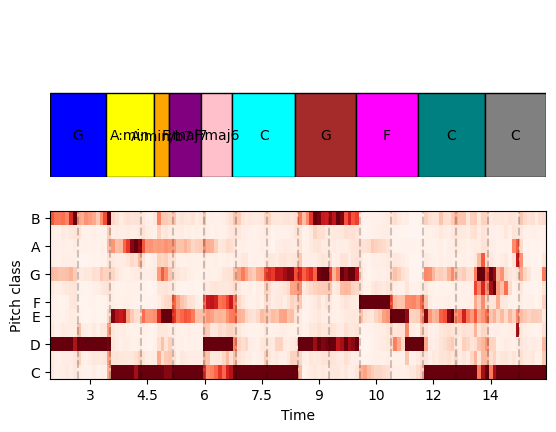

In [25]:

def plotChromagram(ax,t,chroma, beats=None):
    librosa.display.specshow(chroma.T,x_coords=t.T,x_axis='time', y_axis='chroma', cmap="Reds", ax=ax, vmin=0, vmax=1)
    if beats is not None:
        ax.vlines(beats,-0.5,11.5,'k',linestyles='dashed',alpha=0.2)


fig,ax = plt.subplots(2,1)
interval=(2,15)
selection = librosa.time_to_frames(interval,sr=44100,hop_length=4410)
idx = tuple([slice(*list(selection)),slice(None) ])
chroma_selection = np.copy(chroma[idx])
time_vector = np.linspace(interval[0], interval[1], chroma_selection.shape[0], endpoint=False)
beat_selection = featureprocessor.selectBeats(beats,interval)
plotChromagram(ax[1],time_vector,chroma_selection,time_interval=interval, beats=beat_selection)


ref_intervals, ref_labels = target
est_intervals,est_labels = target # estimation not implemented yet
colors = ["red", "green", "blue", "yellow", "orange", "purple", "pink", "cyan", "brown", "magenta", "teal", "gray"]
for i,label in enumerate(ref_labels):
    # skip labels that do not overlap time interval 
    if ref_intervals[i,1] < interval[0] or ref_intervals[i,0] > interval[1]:
        continue
    # set start position of rectangular patch
    if ref_intervals[i,0] < interval[0]:
        t_start = interval[0]
    else: 
        t_start = ref_intervals[i,0]
    if ref_intervals[i,1] > interval[1]:
        t_stop = interval[1]
    else:
        t_stop = ref_intervals[i,1]

    rect = patches.Rectangle((t_start, 0),t_stop - t_start , 1, linewidth=1, edgecolor="k", facecolor=colors[i%len(colors)])
    ax[0].add_patch(rect)
    ax[0].text(t_start+ (t_stop - t_start)/2, 0.5, label,verticalalignment="center",horizontalalignment='center', fontsize=10, color='k')
ax[0].set_xlim(interval)
ax[0].set_ylim(0,2)
ax[0].axis("off")

Text(0.5, 0.5, '$A_m$')

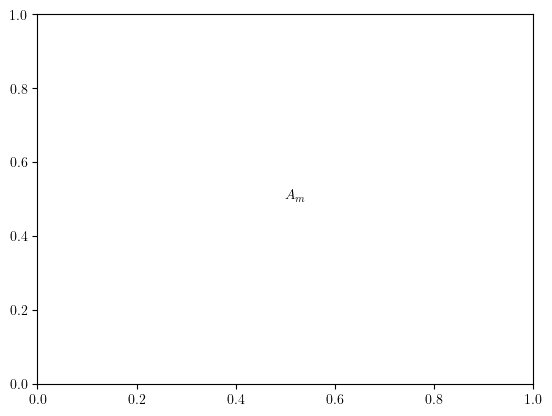

In [6]:
import matplotlib.pyplot as plt
